In [1]:
import warnings
warnings.filterwarnings("ignore")

import logging
import pandas as pd
import os
import gzip

from datetime import datetime
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
####################################################
############# Setear segun cada maquina ############
os.chdir("C:/diego_tools/labo3/dataset")
####################################################

In [4]:
arch_prod_ids_prediccion = "productos_a_predecir.csv"

In [5]:
def error_rate(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    
    #Las predicciones negativas se convierten a 0
    y_pred = np.maximum(y_pred, 0)
    
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)
    
    return round(100*dif_abs/suma_real,2)

In [6]:
def print_error_rate_total_y_cat(df_pred):
    error_rate_total = error_rate(df_pred.tn_real,df_pred.tn_pred)
    printmd("**Error Rate Total:** " + str(error_rate_total))

    for cat1_iter in df_pred.cat1.unique():
        df_pred_cat = df_pred[df_pred.cat1 == cat1_iter]
        error_rate_cat = error_rate(df_pred_cat.tn_real,df_pred_cat.tn_pred)
        printmd("**Error Rate por Categoría " + cat1_iter + "**: " + str(error_rate_cat))

In [7]:
df_sellout = pd.read_csv("emp3_sellout_base_period_product.csv")

In [8]:
df_sellout.head()

,product_id,periodo,imputado,tn,cust_request_tn,cust_request_qty,plan_precios_cuidados,periodo_fecha,mes,meses_historia,...,cat3,brand,sku_size,producto_estrella,temp_media,temp_max_media,temp_min_media,IPC,promedio_mens_dolar_venta,catastrofe
0,20001,201701,0,934.77222,937.72717,479.0,0.0,2017-01-01,1,0,...,Liquido,ARIEL,3000.0,1.0,25.65,30.4,20.9,1.6,15.91,False
1,20001,201702,0,798.01620,833.72187,432.0,0.0,2017-02-01,2,1,...,Liquido,ARIEL,3000.0,1.0,25.35,30.1,20.6,2.1,15.59,False
2,20001,201703,0,1303.35771,1330.74697,509.0,0.0,2017-03-01,3,2,...,Liquido,ARIEL,3000.0,1.0,22.45,26.9,18.0,2.4,15.52,False
3,20001,201704,0,1069.96130,1132.94430,279.0,0.0,2017-04-01,4,3,...,Liquido,ARIEL,3000.0,1.0,18.90,23.5,14.3,2.7,15.36,False
4,20001,201705,0,1502.20132,1550.68936,701.0,0.0,2017-05-01,5,4,...,Liquido,ARIEL,3000.0,1.0,15.90,19.5,12.3,1.4,15.72,False


In [9]:
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35888 entries, 0 to 35887
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_id                 35888 non-null  int64  
 1   periodo                    35888 non-null  int64  
 2   imputado                   35888 non-null  int64  
 3   tn                         35888 non-null  float64
 4   cust_request_tn            35888 non-null  float64
 5   cust_request_qty           35888 non-null  float64
 6   plan_precios_cuidados      35888 non-null  float64
 7   periodo_fecha              35888 non-null  object 
 8   mes                        35888 non-null  int64  
 9   meses_historia             35888 non-null  int64  
 10  cat1                       35888 non-null  object 
 11  cat2                       35888 non-null  object 
 12  cat3                       35888 non-null  object 
 13  brand                      35888 non-null  obj

In [10]:
df_sellout.cat1.value_counts()

PC             19181
HC              8115
FOODS           7160
desconocida     1432
Name: cat1, dtype: int64

In [11]:
# Selecciono las columnas iniciales
df_sellout = df_sellout[["periodo","product_id","tn","cat1"]]

Verificación de producto estrella --> ok

## Split train y test

In [12]:
df_train = df_sellout[df_sellout.periodo <= 201902]
df_test = df_sellout[df_sellout.periodo == 201904]

In [13]:
df_train

,periodo,product_id,tn,cat1
0,201701,20001,934.77222,HC
1,201702,20001,798.01620,HC
2,201703,20001,1303.35771,HC
3,201704,20001,1069.96130,HC
4,201705,20001,1502.20132,HC
...,...,...,...,...
35873,201810,21299,0.00000,desconocida
35874,201811,21299,0.00000,desconocida
35875,201812,21299,0.00000,desconocida
35876,201901,21299,0.00000,desconocida


In [14]:
print(len(df_test))
df_test

1105


,periodo,product_id,tn,cat1
27,201904,20001,1647.63848,HC
63,201904,20002,1287.62346,HC
99,201904,20003,565.33774,FOODS
135,201904,20004,466.70901,FOODS
171,201904,20005,624.99880,FOODS
...,...,...,...,...
35756,201904,21295,0.00000,desconocida
35785,201904,21296,0.00000,desconocida
35821,201904,21297,0.00000,desconocida
35850,201904,21298,0.00000,desconocida


In [15]:
df_prods_prediccion=pd.read_csv(arch_prod_ids_prediccion)
df_prods_prediccion.head()

,product_id
0,20480
1,20481
2,20482
3,20483
4,20484


In [16]:
df_test = df_test[df_test.product_id.isin(df_prods_prediccion.product_id)]
len(df_test)

868

## Predicción Arima

In [17]:
# Convierto columna periodo en fecha
df_train["periodo"] = pd.to_datetime(df_train.periodo,format="%Y%m")
df_train.tail()

,periodo,product_id,tn,cat1
35873,2018-10-01,21299,0.0,desconocida
35874,2018-11-01,21299,0.0,desconocida
35875,2018-12-01,21299,0.0,desconocida
35876,2019-01-01,21299,0.0,desconocida
35877,2019-02-01,21299,0.0,desconocida


In [18]:
df_arima_pred = pd.DataFrame(columns=["product_id","cat1","tn_real","tn_pred"])

0 ) 20001


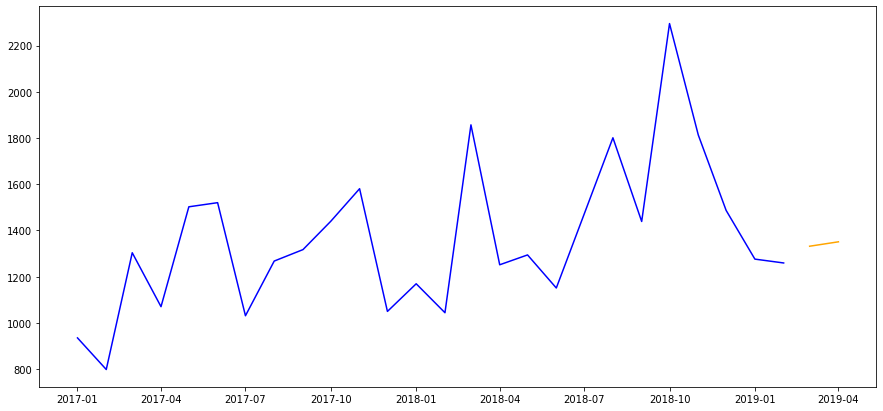

10 ) 20011
20 ) 20021
30 ) 20031
40 ) 20042
50 ) 20052
60 ) 20062
70 ) 20072
80 ) 20082
90 ) 20092
100 ) 20103


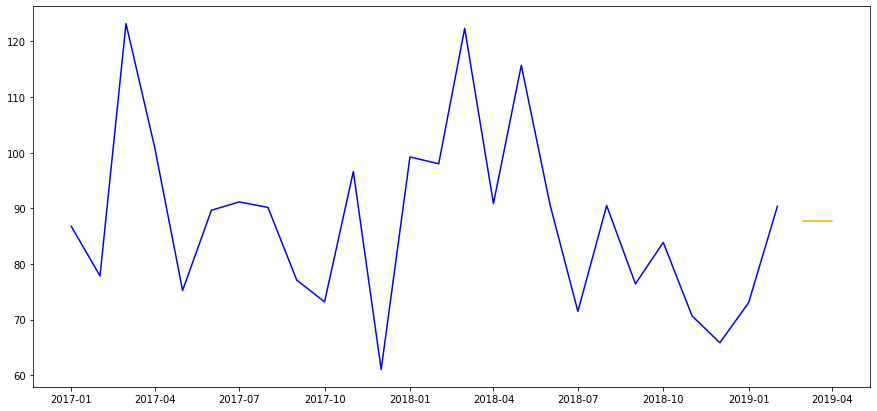

110 ) 20115
120 ) 20125
130 ) 20136
140 ) 20147
150 ) 20158
160 ) 20168
170 ) 20179
180 ) 20189
190 ) 20200
200 ) 20212


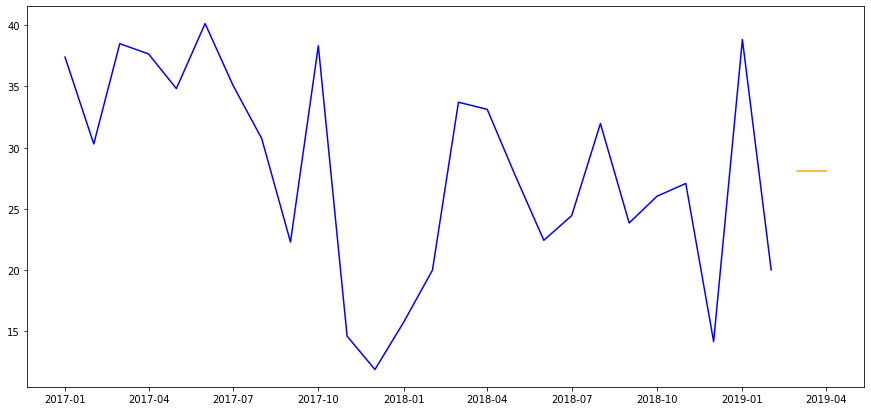

210 ) 20224
220 ) 20234
230 ) 20246
240 ) 20259
250 ) 20271
260 ) 20282
270 ) 20293
280 ) 20304
290 ) 20314
300 ) 20324


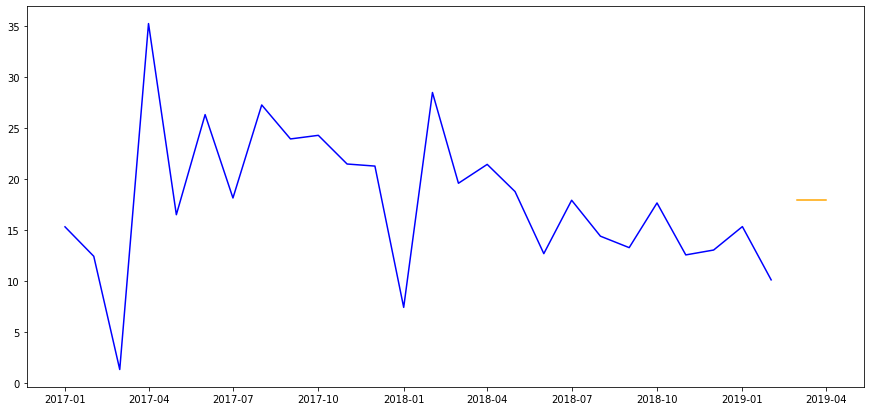

310 ) 20336
320 ) 20348
330 ) 20359
340 ) 20369
350 ) 20382
360 ) 20393
370 ) 20403
380 ) 20413
390 ) 20424
400 ) 20435


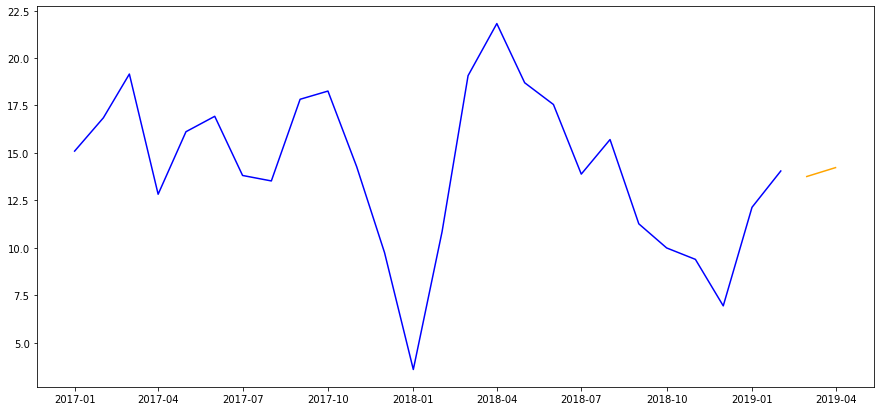

410 ) 20449
420 ) 20463
430 ) 20474
440 ) 20485
450 ) 20501
460 ) 20516
470 ) 20532
480 ) 20543
490 ) 20558
500 ) 20569


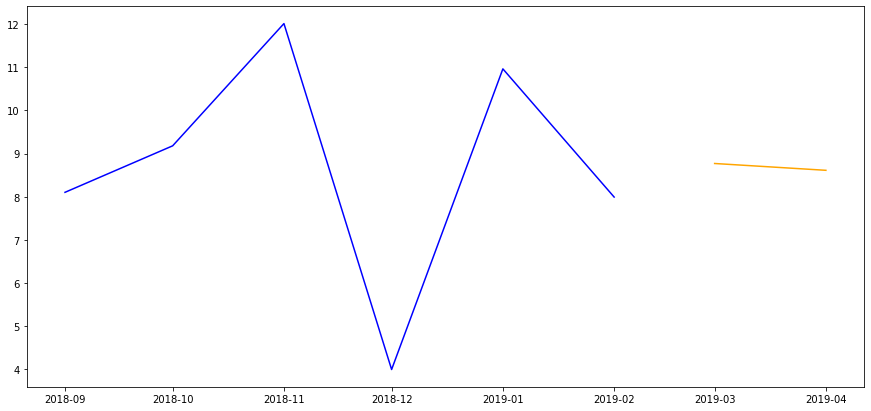

510 ) 20582
520 ) 20596
530 ) 20607
540 ) 20625
550 ) 20639
560 ) 20651
570 ) 20663
580 ) 20678
590 ) 20697
600 ) 20710


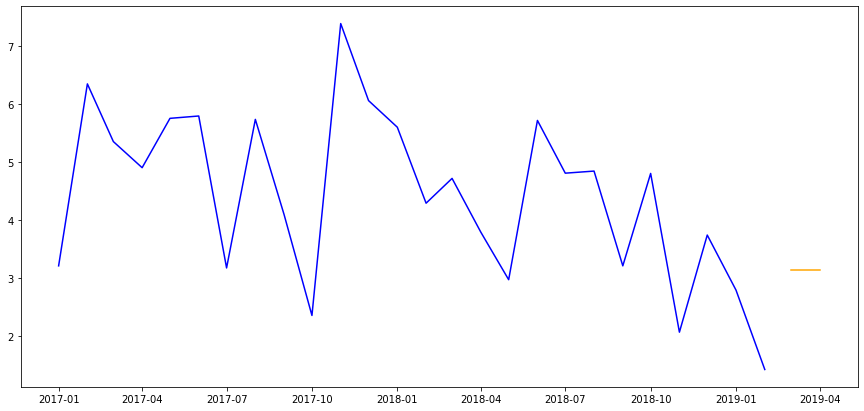

610 ) 20729
620 ) 20744
630 ) 20763
640 ) 20778
650 ) 20790
660 ) 20805
670 ) 20818
680 ) 20832
690 ) 20847
700 ) 20864


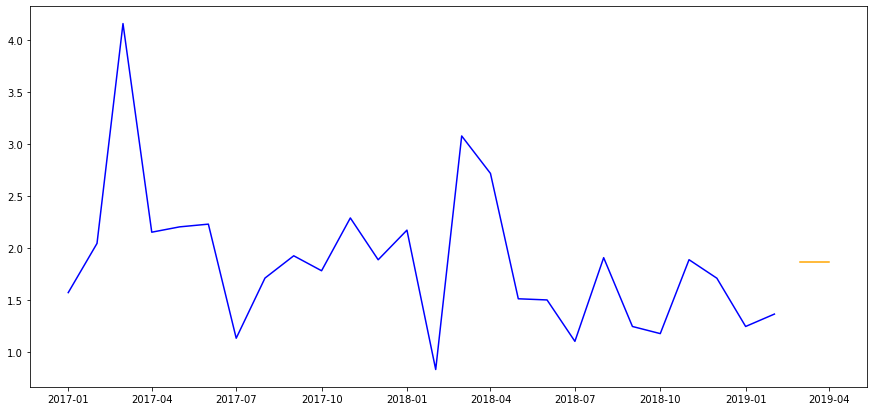

710 ) 20883
720 ) 20903
730 ) 20930
740 ) 20948
750 ) 20967
760 ) 20984
770 ) 20999
780 ) 21020
790 ) 21037
800 ) 21057


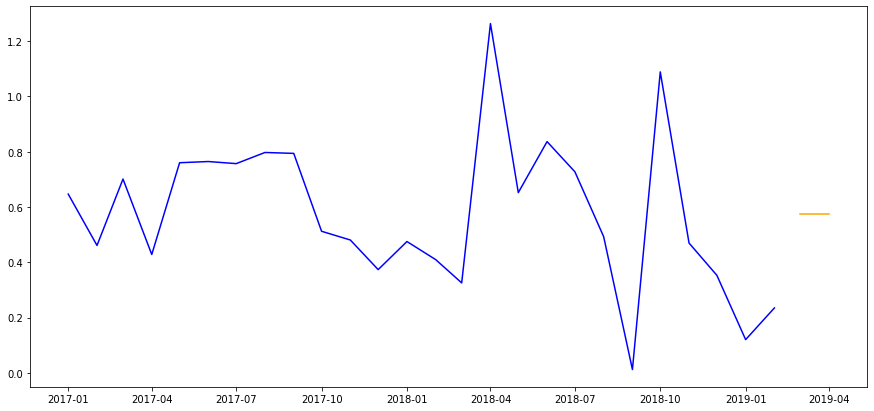

810 ) 21093
820 ) 21131
830 ) 21176
840 ) 21194
850 ) 21222
860 ) 21256


In [19]:
i = 0
for prod_id in df_test.product_id:
    if i%10==0:
        print(i,")", prod_id)
    
    df_arima = df_train[df_train.product_id==prod_id]
    df_arima.set_index(df_arima.periodo,inplace=True,drop=True)
    df_real = df_test[df_test.product_id==prod_id]

    ARIMA_model = pm.auto_arima(df_arima['tn'], 
                      start_p=1, 
                      start_q=1,
                      test='kpss', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      #m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
    
    fitted = ARIMA_model.predict(n_periods=2, return_conf_int=False)
    df_arima_pred = df_arima_pred.append({"product_id":int(df_real.product_id),
                                          "cat1":df_real.iat[0,3],
                                          'tn_real': float(df_real.tn), 
                                          'tn_pred': float(fitted.tail(1))},
                                        ignore_index=True)


    if i%100==0:
        ## Plot
        index_of_fc = pd.date_range(df_arima.periodo.max() + pd.DateOffset(months=1), periods = 2, freq='MS')
        fitted_series = pd.Series(fitted, index=index_of_fc)
        plt.figure(figsize=(15,7))
        plt.plot(df_arima["periodo"],df_arima["tn"], color='blue')
        plt.plot(fitted_series, color='orange')  
        plt.show()
        
    i = i+1

In [20]:
df_arima_pred[df_arima_pred.product_id==20001]

,product_id,cat1,tn_real,tn_pred
0,20001,HC,1647.63848,1350.644095


In [21]:
print_error_rate_total_y_cat(df_arima_pred)

**Error Rate Total:** 29.25

**Error Rate por Categoría HC**: 26.08

**Error Rate por Categoría FOODS**: 33.9

**Error Rate por Categoría PC**: 35.03

**Error Rate por Categoría desconocida**: nan